# Bias-correct CESM2 LENS temperature data using ERA5 reanalysis

In [1]:
# Display output of plots directly in Notebook
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import intake
import numpy as np
import pandas as pd
import xarray as xr
# import s3fs
import seaborn as sns
import re
# import nest_asyncio
# nest_asyncio.apply()
import xesmf as xe

In [2]:
import fsspec.implementations.http as fshttp
from pelicanfs.core import PelicanFileSystem, PelicanMap, OSDFFileSystem 

In [3]:
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from dask.distributed import performance_report

In [4]:
init_year0  = '1991'
init_year1  = '2020'
final_year0 = '2071'
final_year1 = '2100'

In [5]:
def to_daily(ds):
    year = ds.time.dt.year
    day = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), day=("time", day.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "day")).unstack("time")

In [6]:
rda_scratch = '/gpfs/csfs1/collections/rda/scratch/harshah'
zarr_path   = rda_scratch + "/tas_zarr/"
mean_path   = zarr_path + "/means/"
stdev_path  = zarr_path + "/stdevs/"

## Create a PBS cluster

In [7]:
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'dask-wk24-hpc',
    cores = 1,
    memory = '8GiB',
    processes = 1,
    local_directory = rda_scratch+'/dask/spill',
    log_directory = rda_scratch + '/dask/logs/',
    resource_spec = 'select=1:ncpus=1:mem=8GB',
    queue = 'casper',
    walltime = '5:00:00',
    #interface = 'ib0'
    interface = 'ext'
)

In [8]:
cluster.scale(20)

In [9]:
cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.96:42201,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Load CESM LENS2 temperature data

In [10]:
cesm_cat = intake.open_esm_datastore(rda_scratch + '/intake_catalogs/posix/aws-cesm2-le.json')
cesm_cat

,unique
Unnamed: 0,322
variable,53
long_name,51
component,4
experiment,2
forcing_variant,2
frequency,3
vertical_levels,3
spatial_domain,3
units,20


In [11]:
cesm_temp = cesm_cat.search(variable ='TREFHTMX', frequency ='daily')
cesm_temp

,unique
Unnamed: 0,4
variable,1
long_name,1
component,1
experiment,2
forcing_variant,2
frequency,1
vertical_levels,1
spatial_domain,1
units,1


In [12]:
cesm_temp.df['path'].values

array(['/glade/campaign/collections/rda/transfer/chifan_AWS/ncar-cesm2-lens/atm/daily/cesm2LE-historical-cmip6-TREFHTMX.zarr',
       '/glade/campaign/collections/rda/transfer/chifan_AWS/ncar-cesm2-lens/atm/daily/cesm2LE-historical-smbb-TREFHTMX.zarr',
       '/glade/campaign/collections/rda/transfer/chifan_AWS/ncar-cesm2-lens/atm/daily/cesm2LE-ssp370-cmip6-TREFHTMX.zarr',
       '/glade/campaign/collections/rda/transfer/chifan_AWS/ncar-cesm2-lens/atm/daily/cesm2LE-ssp370-smbb-TREFHTMX.zarr'],
      dtype=object)

In [13]:
dsets_cesm = cesm_temp.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


In [14]:
historical_smbb  = dsets_cesm['atm.historical.daily.smbb']
future_smbb      = dsets_cesm['atm.ssp370.daily.smbb']

historical_cmip6 = dsets_cesm['atm.historical.daily.cmip6']
future_cmip6     = dsets_cesm['atm.ssp370.daily.cmip6']

In [ ]:
%%time
merge_ds_smbb = xr.concat([historical_smbb, future_smbb], dim='time')
merge_ds_smbb = merge_ds_smbb.dropna(dim='member_id')

merge_ds_cmip6= xr.concat([historical_cmip6, future_cmip6], dim='time')
merge_ds_cmip6 = merge_ds_cmip6.dropna(dim='member_id')

In [ ]:
t_smbb      = merge_ds_smbb.TREFHTMX
t_cmip6     = merge_ds_cmip6.TREFHTMX
t_init_cmip6 = t_cmip6.sel(time=slice(init_year0, init_year1))
t_init_smbb  = t_smbb.sel(time=slice(init_year0, init_year1))
t_init       = xr.concat([t_init_cmip6,t_init_smbb],dim='member_id')
t_init

In [ ]:
t_init_day = to_daily(t_init)
#t_init_day

In [ ]:
t_fut_cmip6 = t_cmip6.sel(time=slice(final_year0, final_year1))
t_fut_smbb  = t_smbb.sel(time=slice(final_year0, final_year1))
t_fut       = xr.concat([t_fut_cmip6,t_fut_smbb],dim='member_id')
t_fut_day   = to_daily(t_fut)
t_fut_day

### Save means and standard deviations

In [ ]:
# init_means   = t_init_day.mean({'year','member_id'})
# init_stdevs  = t_init_day.std({'year','member_id'})
# final_means  = t_fut_day.mean({'year','member_id'})
# final_stdevs = t_fut_day.std({'year','member_id'})
#
init_ensemble_means  = t_init_day.mean({'member_id'})
final_ensemble_means = t_fut_day.mean({'member_id'})

- Save the overall means, standard devaitions and the ensemble means
- We will regrid the 'final/EOC' ensemble means onto the ERA5 grid.
- We will then compare it with the bias-corrected future predictions obtained from ERA5

In [21]:
# %%time
# init_means.to_dataset().to_zarr(mean_path + 'cesm2_'+ init_year0 + '_' + init_year1+ '_means.zarr',mode='w')
# init_stdevs.to_dataset().to_zarr(stdev_path + 'cesm2_'+ init_year0 + '_' + init_year1+ '_stdevs.zarr',mode='w') 
# final_means.to_dataset().to_zarr(mean_path + 'cesm2_'+ final_year0 + '_' + final_year1+ '_means.zarr',mode='w')
# final_stdevs.to_dataset().to_zarr(stdev_path + 'cesm2_'+ final_year0 + '_' + final_year1+ '_stdevs.zarr',mode='w') 
init_ensmeble_means.to_dataset().to_zarr(mean_path + 'cesm2_'+ init_year0 + '_' + init_year1 \
                                         + '_ensemble_means.zarr',mode='w')
final_ensemble_means.to_dataset().to_zarr(mean_path + 'cesm2_'+ final_year0 + '_' + final_year1 \
                                          + '_ensemble_means.zarr',mode='w')

## Access ERA5 data and regrid CESM2 LENS data on the finer, ERA5 grid

In [22]:
%%time
tas_daily = xr.open_zarr(zarr_path + "e5_tas2m_daily_1940_2023.zarr").VAR_2T
tas_init = tas_daily.sel(time=slice(init_year0, init_year1))
tas_init

CPU times: user 9.64 ms, sys: 0 ns, total: 9.64 ms
Wall time: 9.85 ms


<xarray.DataArray 'VAR_2T' (time: 10958, latitude: 721, longitude: 1440)> Size: 46GB
dask.array<getitem, shape=(10958, 721, 1440), dtype=float32, chunksize=(1000, 139, 544), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 88kB 1991-01-01 1991-01-02 ... 2020-12-31
Attributes: (12/14)
    QuantizeGranularBitGroomNumberOfSignificantDigits:  7
    ecmwf_local_table:                                  128
    ecmwf_parameter:                                    167
    grid_specification:                                 0.25 degree x 0.25 de...
    long_name:                                          2 metre temperature
    maximum_value:                                      320.42938232421875
    ...                                                 ...
    rda_dataset:                                        ds633.0
    rda_dataset_doi:                                    DOI: 10.5065/BH6N-5N20
    rda_dataset_group:                                  ERA5 atmospheric surf...
    rda_dataset_url:                                    https:/rda.ucar.edu/d...
    short_name:                                         2t
    units:                                              K

In [23]:
init_means_ds = xr.open_zarr(mean_path + 'cesm2_'+ init_year0 + '_' + init_year1+ '_means.zarr')
init_means    = init_means_ds.TREFHTMX
init_means

<xarray.DataArray 'TREFHTMX' (lat: 192, lon: 288, day: 365)> Size: 81MB
dask.array<open_dataset-TREFHTMX, shape=(192, 288, 365), dtype=float32, chunksize=(192, 288, 365), chunktype=numpy.ndarray>
Coordinates:
  * day      (day) int64 3kB 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

In [24]:
final_means  = xr.open_zarr(mean_path  + 'cesm2_'+ final_year0 + '_' + final_year1+ '_means.zarr').TREFHTMX
init_stdevs  = xr.open_zarr(stdev_path + 'cesm2_'+ init_year0 + '_' + init_year1+ '_stdevs.zarr').TREFHTMX
final_stdevs = xr.open_zarr(stdev_path + 'cesm2_'+ final_year0 + '_' + final_year1+ '_stdevs.zarr').TREFHTMX

In [25]:
#Create output grid
ds_out = xr.Dataset(
    coords={
        'latitude': tas_init.coords['latitude'],
        'longitude': tas_init.coords['longitude']
    }
)
ds_out = ds_out.rename({'latitude':'lat','longitude':'lon'})
ds_out

<xarray.Dataset> Size: 17kB
Dimensions:  (lat: 721, lon: 1440)
Coordinates:
  * lat      (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
Data variables:
    *empty*

In [35]:
tas_initial    = to_daily(tas_init)
tas_initial    = tas_initial.rename({'latitude':'lat','longitude':'lon'})
tas_initial    = tas_initial.chunk({'lat':139,'lon':544,'year':3,'day':90})
tas_initial 

<xarray.DataArray 'VAR_2T' (lat: 721, lon: 1440, year: 30, day: 366)> Size: 46GB
dask.array<rechunk-merge, shape=(721, 1440, 30, 366), dtype=float32, chunksize=(139, 544, 3, 90), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 240B 1991 1992 1993 1994 1995 ... 2017 2018 2019 2020
  * day      (day) int64 3kB 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365 366
  * lat      (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
Attributes: (12/14)
    QuantizeGranularBitGroomNumberOfSignificantDigits:  7
    ecmwf_local_table:                                  128
    ecmwf_parameter:                                    167
    grid_specification:                                 0.25 degree x 0.25 de...
    long_name:                                          2 metre temperature
    maximum_value:                                      320.42938232421875
    ...                                                 ...
    rda_dataset:                                        ds633.0
    rda_dataset_doi:                                    DOI: 10.5065/BH6N-5N20
    rda_dataset_group:                                  ERA5 atmospheric surf...
    rda_dataset_url:                                    https:/rda.ucar.edu/d...
    short_name:                                         2t
    units:                                              K

In [36]:
# %%time
# tas_initial.to_dataset().to_zarr(zarr_path + "e5_tas2m_initial_1991_2020.zarr",mode='w')

CPU times: user 2min 16s, sys: 1min 28s, total: 3min 44s
Wall time: 4min 34s


In [37]:
tas_initial = xr.open_zarr(zarr_path + "e5_tas2m_initial_1991_2020.zarr").VAR_2T

In [27]:
%%time 
regridder = xe.Regridder(init_means_ds, ds_out, "bilinear")
regridder

CPU times: user 15.6 s, sys: 730 ms, total: 16.3 s
Wall time: 17.6 s


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_192x288_721x1440.nc 
Reuse pre-computed weights? False 
Input grid shape:           (192, 288) 
Output grid shape:          (721, 1440) 
Periodic in longitude?      False

In [28]:
init_means_regrid = regridder(init_means, keep_attrs=True)
init_means_regrid

<xarray.DataArray 'TREFHTMX' (day: 365, lat: 721, lon: 1440)> Size: 2GB
dask.array<astype, shape=(365, 721, 1440), dtype=float32, chunksize=(365, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * day      (day) int64 3kB 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
  * lat      (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
Attributes:
    regrid_method:  bilinear

In [29]:
%%time
# Regrid other variables
init_stdevs_regrid  = regridder(init_stdevs, keep_attrs=True)
final_means_regrid  = regridder(final_means, keep_attrs=True)
final_stdevs_regrid = regridder(final_stdevs, keep_attrs=True)

CPU times: user 928 ms, sys: 15.4 ms, total: 944 ms
Wall time: 1.05 s


In [30]:
# %%time
# #Save regridded data
# init_means_regrid.to_dataset().to_zarr(mean_path + 'cesm2_'+ init_year0 + '_' + init_year1+ '_means_regridded.zarr',mode='w')
# init_stdevs_regrid.to_dataset().to_zarr(stdev_path + 'cesm2_'+ init_year0 + '_' + init_year1+ '_stdevs_regridded.zarr',mode='w') 
# final_means_regrid.to_dataset().to_zarr(mean_path + 'cesm2_'+ final_year0 + '_' + final_year1+ '_means_regridded.zarr',mode='w')
# final_stdevs_regrid.to_dataset().to_zarr(stdev_path + 'cesm2_'+ final_year0 + '_' + final_year1+ '_stdevs_regridded.zarr',mode='w')

CPU times: user 33.8 s, sys: 14.2 s, total: 48 s
Wall time: 53.4 s


In [32]:
%%time
# Open regridded data
init_means_regrid  = xr.open_zarr(mean_path + 'cesm2_'+ init_year0 + '_' + init_year1+ '_means_regridded.zarr').TREFHTMX
init_stdevs_regrid = xr.open_zarr(stdev_path + 'cesm2_'+ init_year0 + '_' + init_year1+ '_stdevs_regridded.zarr').TREFHTMX
final_means_regrid  = xr.open_zarr(mean_path + 'cesm2_'+ final_year0 + '_' + final_year1+ '_means_regridded.zarr').TREFHTMX
final_stdevs_regrid = xr.open_zarr(stdev_path + 'cesm2_'+ final_year0 + '_' + final_year1+ '_stdevs_regridded.zarr').TREFHTMX

CPU times: user 12.4 ms, sys: 1e+03 ns, total: 12.4 ms
Wall time: 13.9 ms


## Now, perform bias correction by only adjusting the first moment, i.e, mean and plot

In [38]:
tas_bc = (tas_initial - tas_initial.mean('year')) + (final_means_regrid - init_means_regrid)
tas_bc = tas_bc.chunk({'lat':139,'lon':544,'year':3,'day':90})
tas_bc

<xarray.DataArray (lat: 721, lon: 1440, year: 30, day: 365)> Size: 45GB
dask.array<add, shape=(721, 1440, 30, 365), dtype=float32, chunksize=(139, 544, 3, 90), chunktype=numpy.ndarray>
Coordinates:
  * day      (day) int64 3kB 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
  * lat      (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * year     (year) int64 240B 1991 1992 1993 1994 1995 ... 2017 2018 2019 2020

### Plot bias corrected temperature and CESM model's predictions for the End of the 21st century (2100)
- Since tas_bc are predictions for the years 2070-2100, we need to change the year coordinated
- We will then save the bias-corrected surface air temperatures (tas) to a zarr store.
- Finally, we will read from this zarr store and plot

In [39]:
# Change the year coordinate
tas_bc['year'] = tas_bc['year'] + 80
tas_bc         = tas_bc.rename('bias_corrected_tas')
tas_bc

<xarray.DataArray 'bias_corrected_tas' (lat: 721, lon: 1440, year: 30, day: 365)> Size: 45GB
dask.array<add, shape=(721, 1440, 30, 365), dtype=float32, chunksize=(139, 544, 3, 90), chunktype=numpy.ndarray>
Coordinates:
  * day      (day) int64 3kB 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
  * lat      (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * year     (year) int64 240B 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100

In [40]:
# %%time
# tas_bc.to_dataset().to_zarr(zarr_path + 'bias_corrected_tas_1991_2020.zarr',mode='w')

CPU times: user 5min 13s, sys: 1min 21s, total: 6min 34s
Wall time: 8min 3s


In [41]:
tas_bc = xr.open_zarr(zarr_path + 'bias_corrected_tas_1991_2020.zarr').bias_corrected_tas
tas_bc

<xarray.DataArray 'bias_corrected_tas' (lat: 721, lon: 1440, year: 30, day: 365)> Size: 45GB
dask.array<open_dataset-bias_corrected_tas, shape=(721, 1440, 30, 365), dtype=float32, chunksize=(139, 544, 3, 90), chunktype=numpy.ndarray>
Coordinates:
  * day      (day) int64 3kB 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
  * lat      (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * year     (year) int64 240B 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100

CPU times: user 894 ms, sys: 520 ms, total: 1.41 s
Wall time: 3.14 s


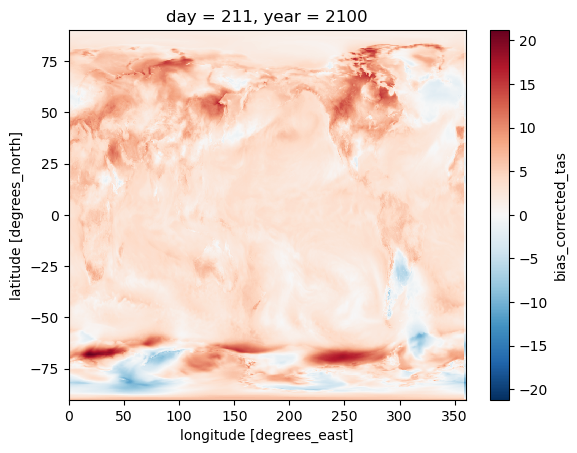

In [42]:
%%time
tas_bc.sel(year = 2100, day = 211).plot()

### Calculate GMST 

In [32]:
# GMST function ###
# calculate global means

def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time','member_id'}
    return (ds * weight).mean(other_dims)

#### Now compute (spatially weighted) Global Mean